In [264]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


## Exploratory Data Analysis
First I display the head of the dataset, along with the descriptions of each feature.

In [265]:
full_data = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')
country_vec = full_data.pop('country')
print(full_data.head())
data_dict = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv')
print("Dataset Dimensions")
descs = [print(f'{dimension[1]["Column Name"]}: {dimension[1]["Description"]}') for dimension in data_dict.iterrows()]

   child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  
0       5.82    553  
1       1.65   4090  
2       2.89   4460  
3       6.16   3530  
4       2.13  12200  
Dataset Dimensions
country: Name of the country
child_mort: Death of children under 5 years of age per 1000 live births
exports: Exports of goods and services per capita. Given as %age of the GDP per capita
health: Total health spending per capita. Given as %age of GDP per capita
imports: Imports of goods and services per capita. Given as %age of the GDP per capita
Income: Net income per person
Inflation: The measuremen

Here I normalize the columns, as Euclidean distance, used in KMeans clustering, can be very sensitive to the magnitude of a given input.

In [266]:
full_data = ((full_data-(full_data.min()))/(full_data.max()-full_data.min())) + 1
print(full_data.head())

   child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.426485  1.049482  1.358608  1.257765  1.008047   1.126144    1.475345   
1    1.068160  1.139531  1.294593  1.279037  1.074933   1.080399    1.871795   
2    1.120253  1.191559  1.146675  1.180149  1.098809   1.187691    1.875740   
3    1.566699  1.311125  1.064636  1.246266  1.042535   1.245911    1.552268   
4    1.037488  1.227079  1.262275  1.338255  1.148652   1.052213    1.881657   

   total_fer      gdpp  
0   1.736593  1.003073  
1   1.078864  1.036833  
2   1.274448  1.040365  
3   1.790221  1.031488  
4   1.154574  1.114242  


## Data Visualization
Here I am checking for the normality of each feature, as KMeans relies on normalized data to function well.

Number of Countries Included:  167


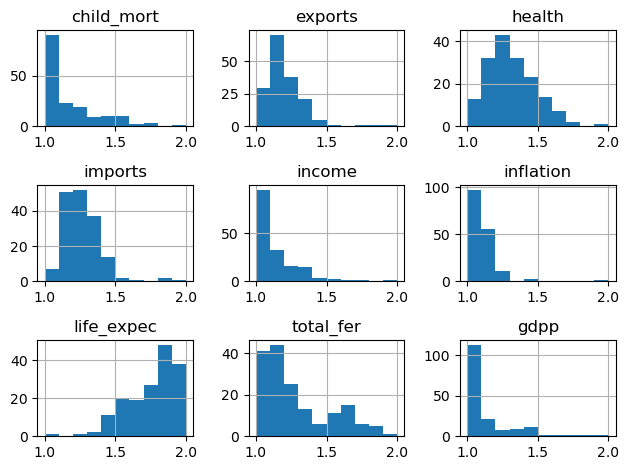

In [267]:
print('Number of Countries Included: ', len(full_data))
fig = plt.figure()
for i, col in enumerate(full_data):
    ax = fig.add_subplot(3, 3, i+1)
    full_data[col].hist(bins=10, ax=ax)
    ax.set_title(str(col))
fig.tight_layout()
plt.show()
#full_data.child_mort.hist()

Some of these histograms show very skewed distributions. To remedy this, we will view the log-transformed data for each column, and select to use the most normalized form of each column. Unfortunately, log transformations do not seem to have an impact on any of the features histograms.

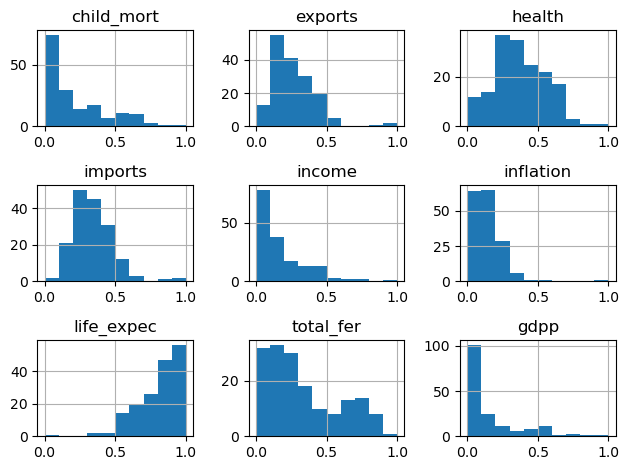

In [268]:
log_data = np.log2(full_data)
fig = plt.figure()
for i, col in enumerate(log_data):
    ax = fig.add_subplot(3, 3, i+1)
    log_data[col].hist(bins=10, ax=ax)
    ax.set_title(str(col))
fig.tight_layout()
plt.show()
#full_data.child_mort.hist()

## Correlation
Here I create a heatmap of the features to discover redundancy in the dataset, and consider removing features.

<AxesSubplot:>

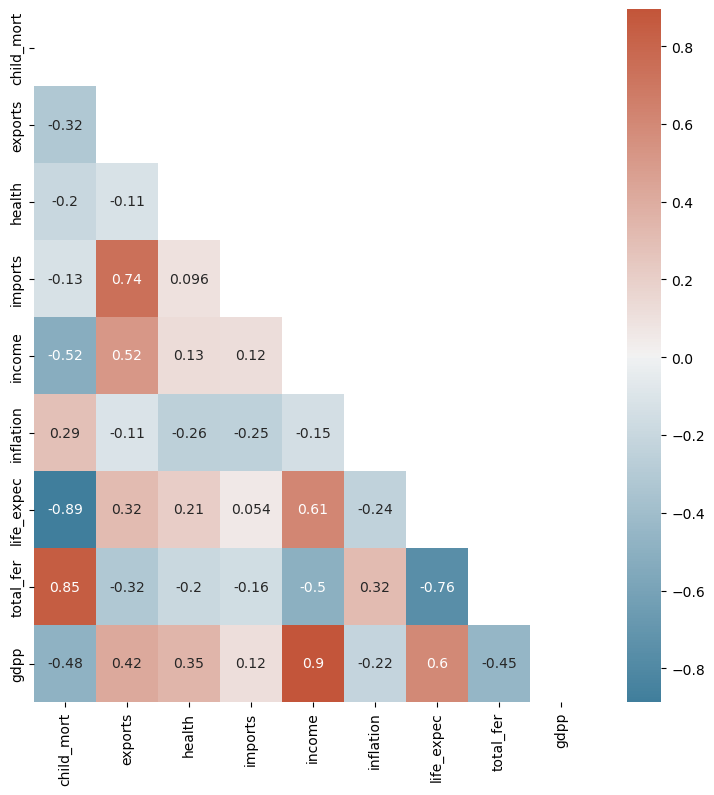

In [269]:
corr = full_data.corr()
f, ax = plt.subplots(figsize= (9,9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

These correlations suggest removing some columns as they are so strongly correlated to others. Firstly, income has a very high correlation with gdpp. For this reason I will remove this column from consideration. Similarly, child_mort has two very strong correlations, and will be removed as well.

In [270]:
no_income_data = full_data.loc[:, full_data.columns != 'income']
removed_data = no_income_data.loc[:, no_income_data.columns != 'child_mort']
print(removed_data.head())

    exports    health   imports  inflation  life_expec  total_fer      gdpp
0  1.049482  1.358608  1.257765   1.126144    1.475345   1.736593  1.003073
1  1.139531  1.294593  1.279037   1.080399    1.871795   1.078864  1.036833
2  1.191559  1.146675  1.180149   1.187691    1.875740   1.274448  1.040365
3  1.311125  1.064636  1.246266   1.245911    1.552268   1.790221  1.031488
4  1.227079  1.262275  1.338255   1.052213    1.881657   1.154574  1.114242


<AxesSubplot:>

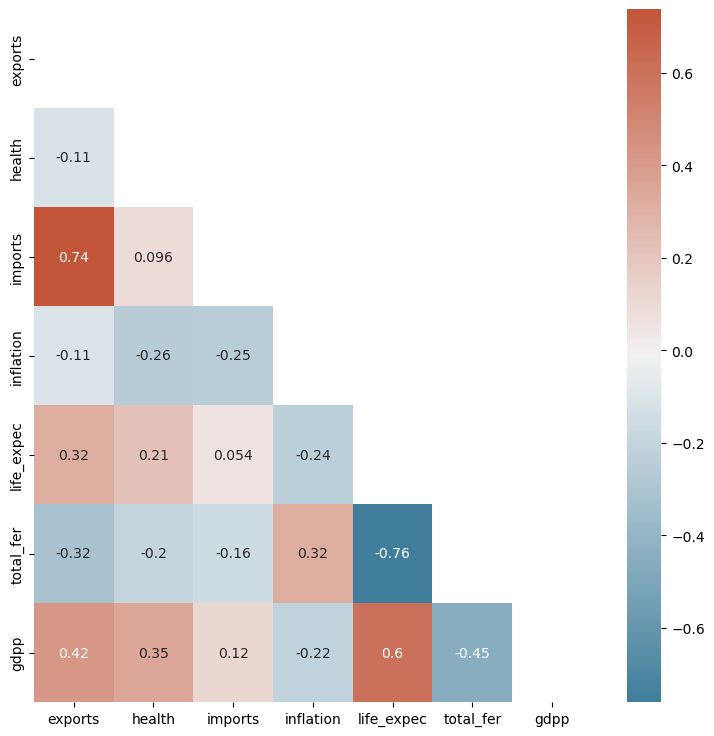

In [271]:
corr = removed_data.corr()
f, ax = plt.subplots(figsize= (9,9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

While we have a few quite strong correlations, in an attempt to retain as much data as possible, two models will be trained, one with life_expec removed, and one retaining.

In [272]:
le_data = removed_data
no_le_data = le_data.loc[:, le_data.columns != 'life_expec']
print(no_le_data.head())

    exports    health   imports  inflation  total_fer      gdpp
0  1.049482  1.358608  1.257765   1.126144   1.736593  1.003073
1  1.139531  1.294593  1.279037   1.080399   1.078864  1.036833
2  1.191559  1.146675  1.180149   1.187691   1.274448  1.040365
3  1.311125  1.064636  1.246266   1.245911   1.790221  1.031488
4  1.227079  1.262275  1.338255   1.052213   1.154574  1.114242


In [273]:
le_data['Country'] = country_vec
no_le_data['Country'] = country_vec
le_data = le_data.dropna()
no_le_data = no_le_data.dropna()
le_names = le_data.pop('Country')
no_le_names = no_le_data.pop('Country')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Model Training and Hyperparameter Optimization
First I must decide the number of clusters in the KMean model. To do so I will measure the inertia and silhouette for a variety of cluster counts. These are measurements of how alike members of the same cluster are, and how different members of different clusters are. The best choice appears to be n_clusters=3 based on maximizing the silhouette and minimizing the inertia.

In [274]:
def plot_inerts(data, max_clusts):
    inerts = []
    K = range(1, max_clusts)
    for num_clusts in range(1,max_clusts):
        inerts.append(KMeans(n_clusters=num_clusts).fit(data).inertia_)
    plt.plot(K,inerts,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return

In [275]:
from sklearn.metrics import silhouette_score
def plot_silhouettes(data, max_clusts):
    K = range(2, max_clusts)
    silos = []
    for num_clusts in range(2, max_clusts):
        cluster_labels = KMeans(n_clusters=num_clusts).fit(data).labels_
        #print(cluster_labels)
        silos.append(silhouette_score(data, cluster_labels))
    plt.plot(K,silos,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

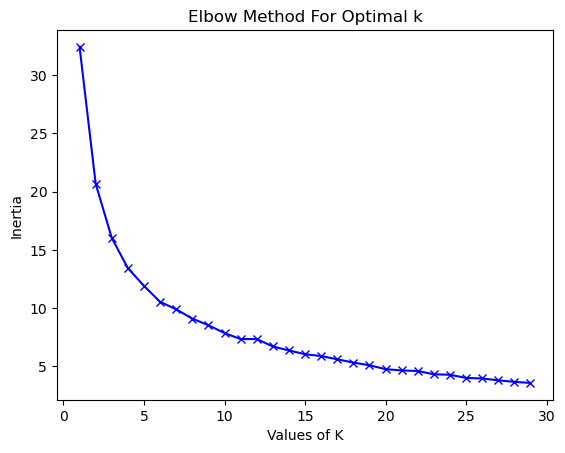

In [276]:
plot_inerts(le_data, 30)

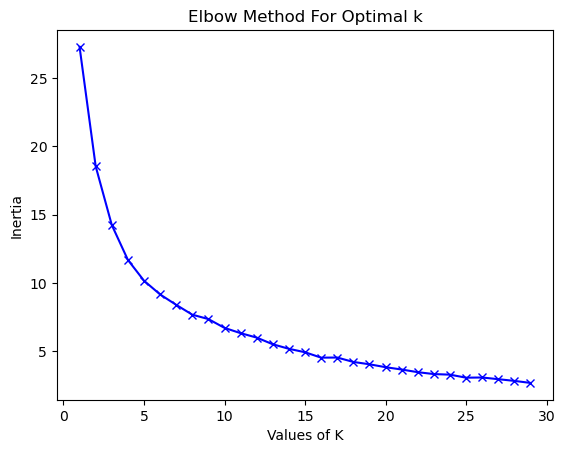

In [277]:
plot_inerts(no_le_data, 30)

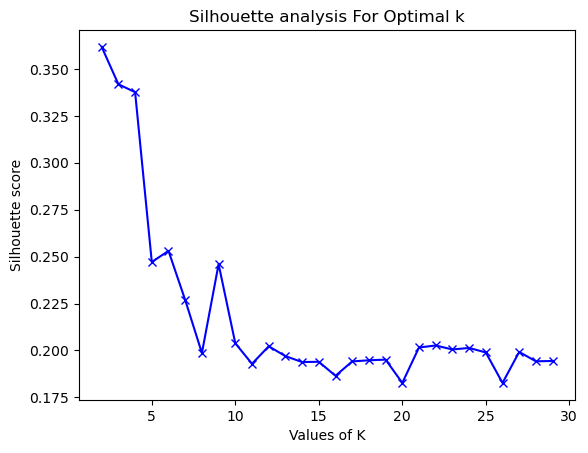

In [278]:
plot_silhouettes(le_data, 30)

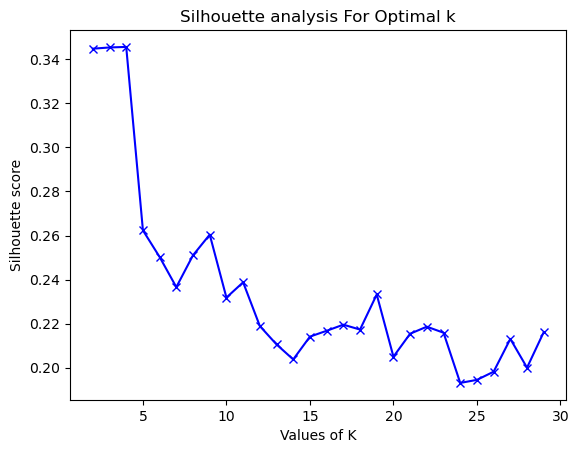

In [279]:
plot_silhouettes(no_le_data, 30)

Deciding on num_clusters=3, I train the model and take a glimpse at the output.

In [280]:
le_data['Cluster'] = KMeans(n_clusters=3, random_state=1101).fit_predict(le_data)
no_le_data['Cluster'] = KMeans(n_clusters=3, random_state=1101).fit_predict(no_le_data)
le_data['Country'] = le_names
no_le_data['Country'] = no_le_names
print(le_data)
print(no_le_data)

      exports    health   imports  inflation  life_expec  total_fer      gdpp  \
0    1.049482  1.358608  1.257765   1.126144    1.475345   1.736593  1.003073   
1    1.139531  1.294593  1.279037   1.080399    1.871795   1.078864  1.036833   
2    1.191559  1.146675  1.180149   1.187691    1.875740   1.274448  1.040365   
3    1.311125  1.064636  1.246266   1.245911    1.552268   1.790221  1.031488   
4    1.227079  1.262275  1.338255   1.052213    1.881657   1.154574  1.114242   
..        ...       ...       ...        ...         ...        ...       ...   
162  1.232582  1.213797  1.302609   1.063118    1.609467   1.370662  1.026143   
163  1.142032  1.192666  1.100809   1.463081    1.854043   1.208202  1.126650   
164  1.359651  1.312617  1.460715   1.150725    1.808679   1.126183  1.010299   
165  1.149536  1.209447  1.197397   1.257000    1.698225   1.555205  1.010299   
166  1.184556  1.253574  1.177275   1.168284    1.392505   1.670347  1.011731   

     Cluster              C

Here I create a pairplot to look at how the clusters are represented by each feature pair. It appears that cluster 2 would consist of the best quality of life, as they have generally higher gdpp, health, life_expec (in the inclusive model), and lower total_fer.

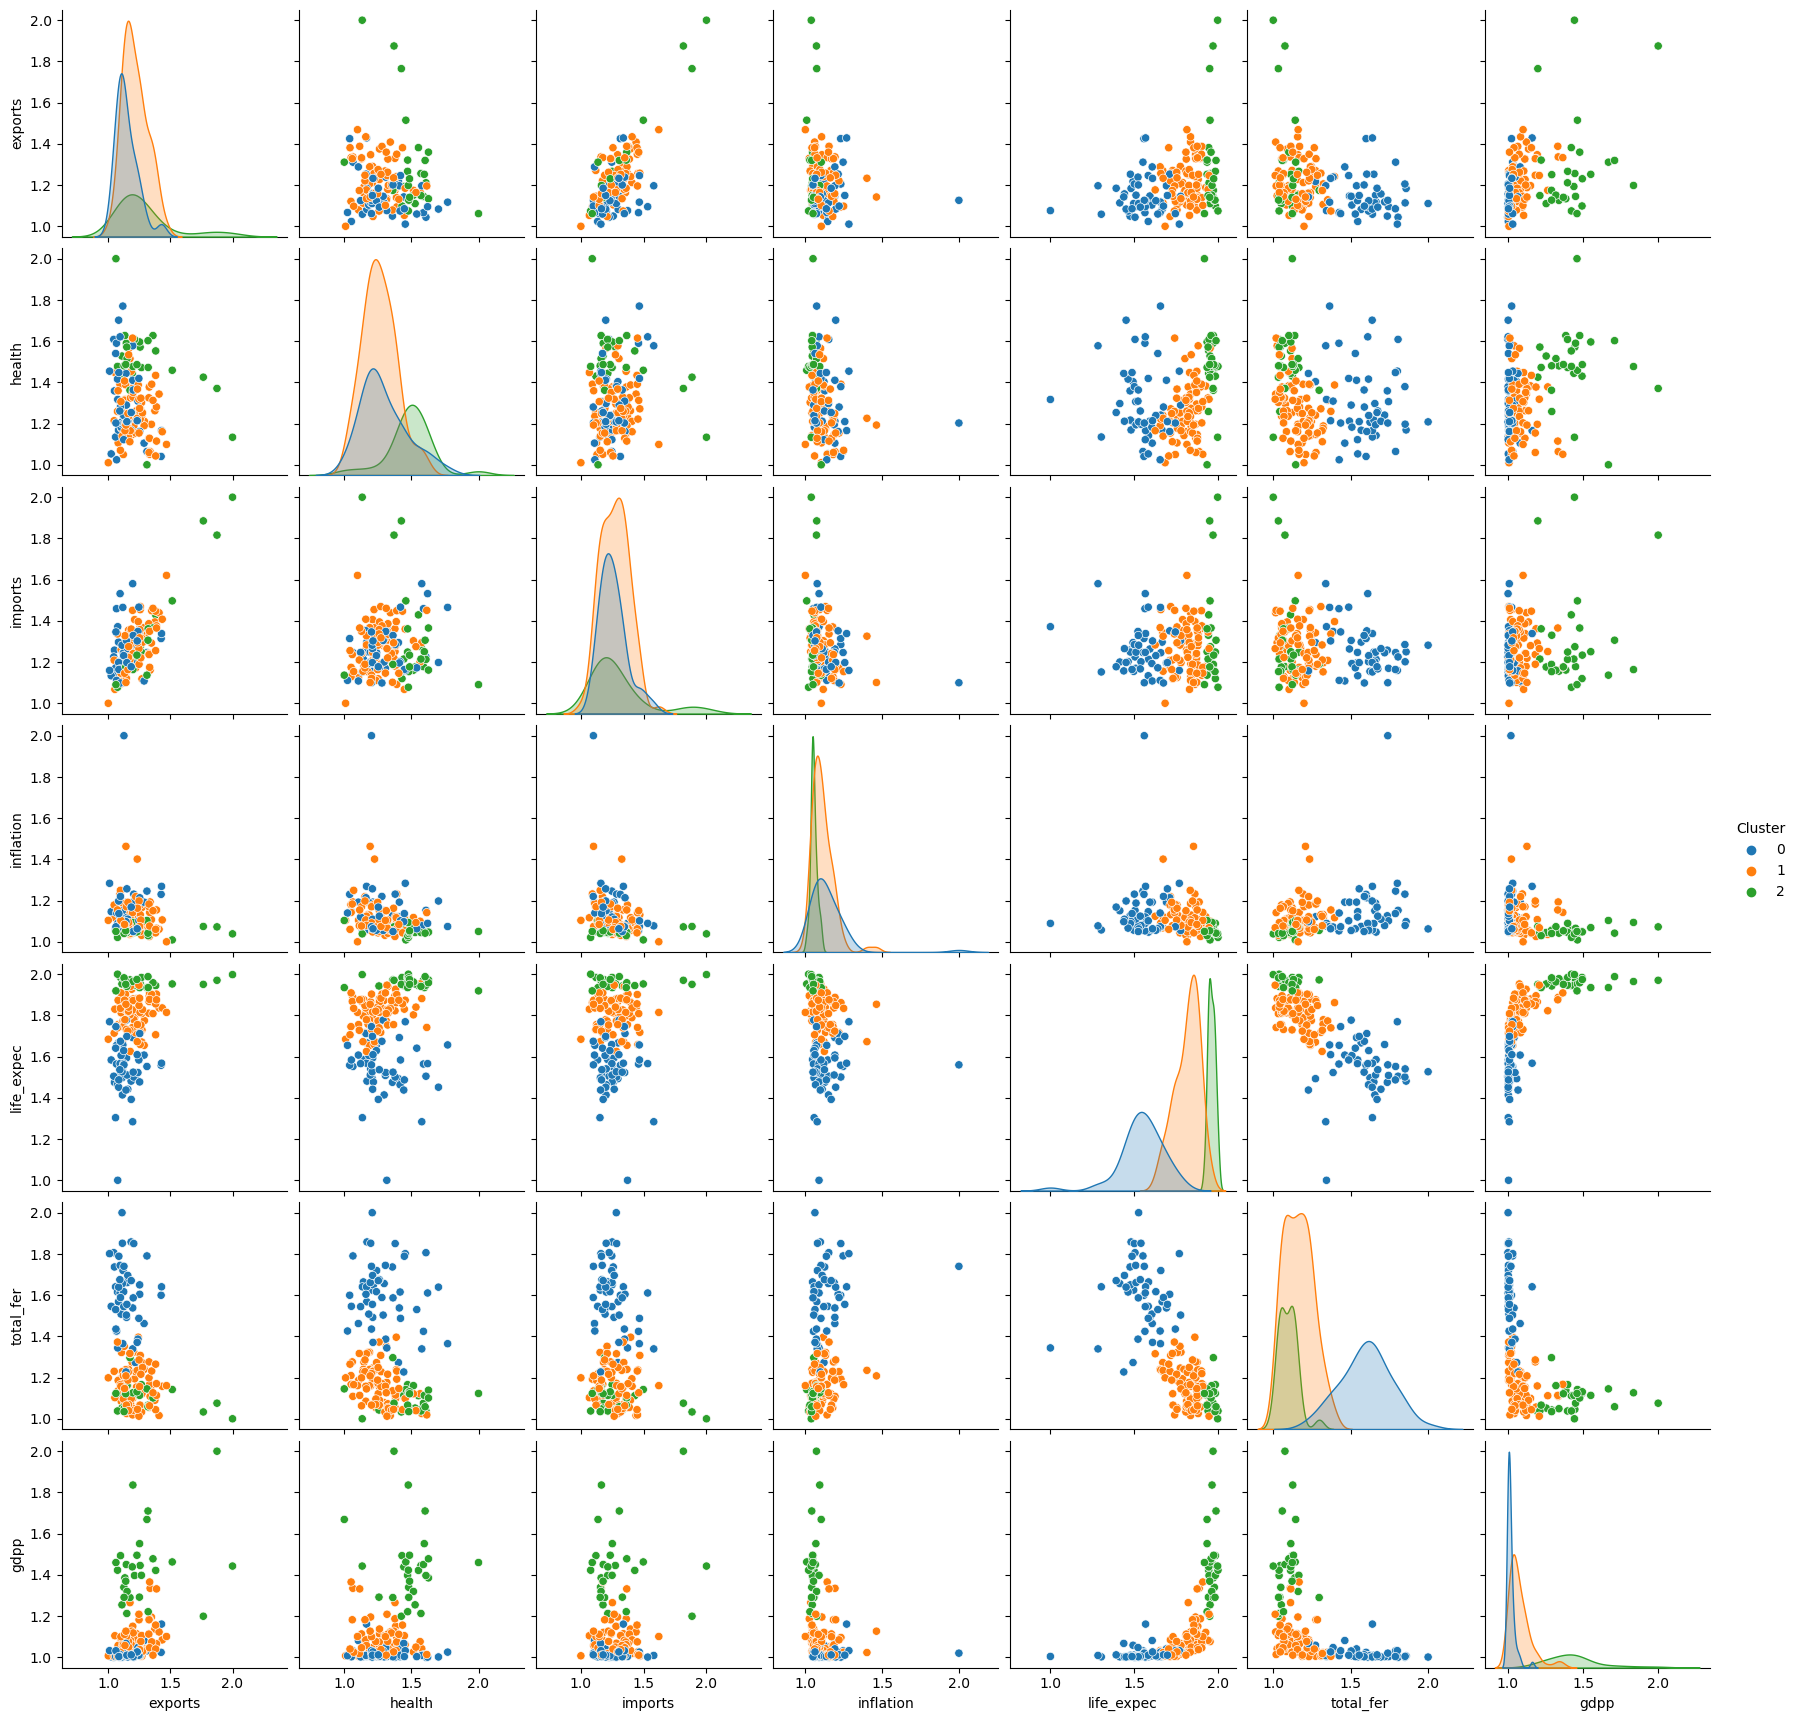

In [282]:
sns.pairplot(le_data, hue='Cluster', palette = 'tab10')

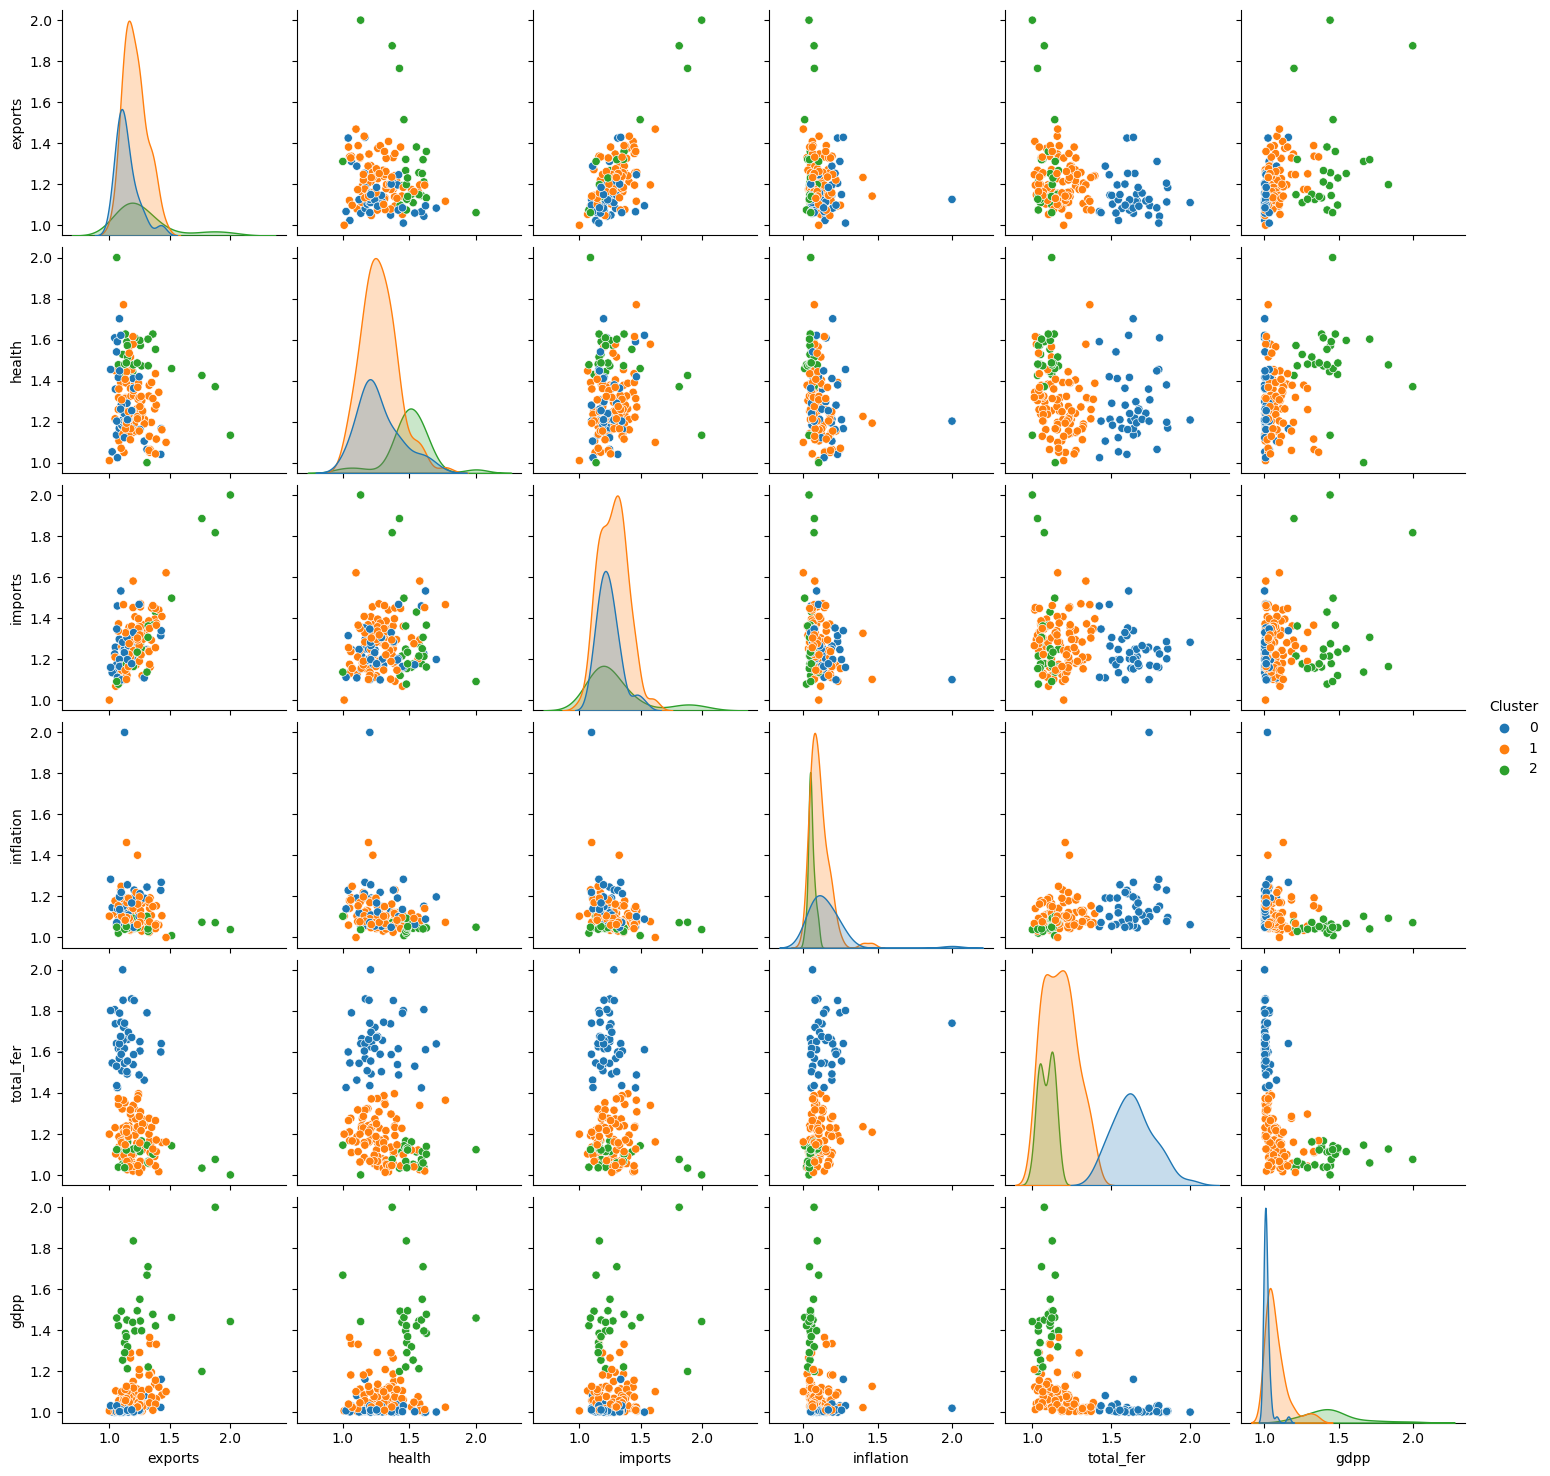

In [283]:
sns.pairplot(no_le_data, hue='Cluster', palette = 'tab10')

In [284]:
#data with life_expec
country_clust = pd.DataFrame()
country_clust = country_clust.assign(Country= le_data['Country'], leCluster=le_data['Cluster'], noleCluster=no_le_data['Cluster'])
country_clust

,Country,leCluster,noleCluster
0,Afghanistan,0,0
1,Albania,1,1
2,Algeria,1,1
3,Angola,0,0
4,Antigua and Barbuda,1,1
...,...,...,...
162,Vanuatu,0,1
163,Venezuela,1,1
164,Vietnam,1,1
165,Yemen,0,0


## Model Comparison
Both models were very similar, but to see how they differed I investigated. It seems that the exclusive model is slightly better, as shown by the silhouette and inertia scores, and tends to place more data points in the 1 cluster, the intermediate cluster.

In [285]:
different = 0
for row in country_clust.iterrows():
    if row[1][1] != row[1][2]:
        different += 1
        print(f'Country {row[1][0]} is in cluster {row[1][1]} including life_expec and {row[1][2]} without.')
print(f'Here we see that there are {different} differences between the le_data clusters and the no_le_data clusters.')

Country Botswana is in cluster 0 including life_expec and 1 without.
Country Cyprus is in cluster 2 including life_expec and 1 without.
Country Haiti is in cluster 0 including life_expec and 1 without.
Country Israel is in cluster 2 including life_expec and 1 without.
Country Lesotho is in cluster 0 including life_expec and 1 without.
Country Micronesia, Fed. Sts. is in cluster 0 including life_expec and 1 without.
Country Namibia is in cluster 0 including life_expec and 1 without.
Country South Africa is in cluster 0 including life_expec and 1 without.
Country Vanuatu is in cluster 0 including life_expec and 1 without.
Here we see that there are 9 differences between the le_data clusters and the no_le_data clusters.


Interestingly enough, every difference between the models results changes the classification from either cluster 0 or 2 to cluster 1 when life_expec is removed from consideration. Since the inertia is slightly lower and silhouette slightly larger for this model, this would seem to reason that the second model, that which is without life_expec, is a bit better at determining differences between the clusters on either end of the spectrum (0 being the worst and 2 being the best) and the cluster in the 'middle' of quality of life.

## Conclusion


In [300]:
country_clust.to_csv('ClusteredCountries.csv')